In [1]:
import os, sys, glob
import h5py
import numpy as np
import matplotlib.pyplot as plt


if os.path.basename(os.getcwd()) == 'notebooks':
    sys.path.append('..')
    os.chdir('..')

import dataset

### Setup a data reader object for OADAT Single wavelength forearm data (SWFD) for semicircle (sc) array 

In [13]:
oadat_dir = '/mydata/dlbirhoui/firat/OADAT' ## switch with path to OADAT parent directory.
fname_SWFDsc = os.path.join(oadat_dir, 'SWFD_semicircle_RawBP.h5')
# fname_SWFDsc = os.path.join(oadat_dir, 'SCD_RawBP-mini.h5')

with h5py.File(fname_SWFDsc, 'r') as f:
    print(f.keys())
    pIDs = f['patientID'][()]
    unique_pIDs = np.unique(pIDs)
    pID_counts = {pID: np.sum(pIDs == pID) for pID in unique_pIDs}
    print(f'Unique patient IDs (and counts): {pID_counts}')
    num_images = f['sc_BP'].shape[0]

key = 'sc_BP' #semi-circle back-projection
prng = np.random.RandomState(42)
scaleclip_fn = lambda x: np.clip(x/np.max(x), a_min=-0.2, a_max=None) ## a standard scaling function for the optoacoustic iamge data.
dataset_obj = dataset.Dataset(fname_h5=fname_SWFDsc, key=key, transforms=scaleclip_fn, inds=None, shuffle=True, prng=prng)


<KeysViewHDF5 ['patientID', 'sc,lv128_BP', 'sc,lv128_raw', 'sc,ss128_BP', 'sc,ss128_raw', 'sc,ss32_BP', 'sc,ss32_raw', 'sc,ss64_BP', 'sc,ss64_raw', 'sc_BP', 'sc_raw', 'side', 'skin_type', 'sliceID']>
Unique patient IDs (and counts): {1: 2802, 2: 2802, 3: 2802, 4: 2802, 5: 2802, 6: 2802, 7: 2802, 8: 2802, 9: 2802, 10: 2802, 11: 2802, 12: 2802, 13: 2802, 14: 2802}


### Display a random image from the dataset

(256, 256)


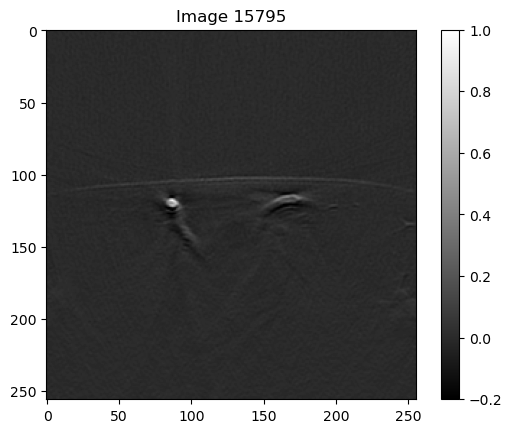

In [14]:
i = prng.randint(0, num_images)
x = dataset_obj[i]
x = x[0] ## drop the channel axis
print(x.shape)
plt.imshow(x, cmap='gray')
plt.title(f'Image {i}')
plt.colorbar()
plt.show()

In [15]:
!pip install diffusers transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 25.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0


In [16]:
from diffusers import AutoencoderKL

# Custom VAE for grayscale images (1-channel)
vae = AutoencoderKL.from_pretrained("CompVis/autoencoder-kl")

# Update the in_channels and out_channels to 1 (for grayscale images)
vae.encoder.conv_in = torch.nn.Conv2d(1, vae.encoder.conv_in.out_channels, kernel_size=3, stride=1, padding=1)
vae.decoder.conv_out = torch.nn.Conv2d(vae.decoder.conv_out.in_channels, 1, kernel_size=3, stride=1, padding=1)

# Function to encode grayscale images
def encode_grayscale_images(images):
    latents = vae.encode(images).latent_dist.sample()
    latents = 0.18215 * latents
    return latents

# Function to decode latent representations back to grayscale images
def decode_latents_to_grayscale(latents):
    latents = latents / 0.18215
    decoded_images = vae.decode(latents).sample()
    return decoded_images


/myhome/micromamba/envs/oadatldm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
/myhome/micromamba/envs/oadatldm/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


OSError: CompVis/autoencoder-kl is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `token` or log in with `huggingface-cli login`.

In [ ]:
from diffusers import UNet2DConditionModel

# Create a U-Net model for grayscale latent space (1-channel latent vectors)
unet = UNet2DConditionModel(
    sample_size=64,  # size of the latent space image
    in_channels=1,   # since we're working with grayscale images, change in_channels to 1
    out_channels=1,  # output should also be 1-channel for grayscale
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("UpBlock2D", "UpBlock2D", "UpBlock2D", "AttnUpBlock2D"),
)


In [ ]:
from torchvision import transforms
from PIL import Image

# Define transformation for loading grayscale images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are loaded as 1-channel
    transforms.Resize((64, 64)),  # Resize images if necessary
    transforms.ToTensor(),  # Convert to PyTorch tensors
])

# Example of loading a grayscale image
image = Image.open("path_to_image.png")
image = transform(image)


In [ ]:
from diffusers import DDPMScheduler

# Create a noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # Number of diffusion steps during training
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",  # You can try different schedules (linear, cosine, etc.)
)

In [ ]:
for epoch in range(num_epochs):
    for step, images in enumerate(train_dataloader):
        images = images.to(device)  # Grayscale images are now single-channel

        # Encode images to latent space
        latents = encode_grayscale_images(images)

        # Sample a random timestep
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()

        # Add noise to the latent images
        noise = torch.randn_like(latents)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict the noise using U-Net
        noise_pred = unet(noisy_latents, timesteps).sample

        # Calculate the loss (MSE loss between predicted noise and actual noise)
        loss = nn.MSELoss()(noise_pred, noise)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss for monitoring
        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}, Loss: {loss.item()}")


In [17]:
import requests
from PIL import Image
from io import BytesIO
from diffusers import LDMSuperResolutionPipeline
import torch

# load model and scheduler
pipeline = LDMSuperResolutionPipeline.from_pretrained("CompVis/ldm-super-resolution-4x-openimages")
pipeline = pipeline.to("cuda")

# let's download an  image
url = (
    "https://user-images.githubusercontent.com/38061659/199705896-b48e17b8-b231-47cd-a270-4ffa5a93fa3e.png"
)
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img = low_res_img.resize((128, 128))

# run pipeline in inference (sample random noise and denoise)
upscaled_image = pipeline(low_res_img, num_inference_steps=100, eta=1).images[0]
# save image
upscaled_image.save("ldm_generated_image.png")